## Import libs

In [1]:
from math import sqrt, isnan
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.dataset import Dataset as madras_Dataset
from util import read_data as rd
from util import metrics

from zhang.models import FairLogisticRegression

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

## Load data

In [3]:
data_name = 'adult'

data_info = rd.return_data_info(data_name)
npzfile = rd.return_npz(data_name)

data = madras_Dataset(npzfile=npzfile, name=data_name, a0_name=data_info['a0_name'], a1_name=data_info['a1_name'], 
                use_a=data_info['use_a'], seed=data_info['seed'], batch_size=batch_size)

data_shapes = list(data.get_shapes())
#print(data_shapes)

xdim = data_shapes[0][1]
ydim = data_shapes[1][1]
adim = data_shapes[2][1]
zdim = 8

In [4]:
train_data = Dataset.from_tensor_slices((data.x_train, data.y_train, data.a_train))
train_data = train_data.batch(batch_size)
train_data

<BatchDataset shapes: ((None, 113), (None, 1), (None, 1)), types: (tf.float64, tf.float32, tf.float32)>

In [5]:
valid_data = Dataset.from_tensor_slices((data.x_valid, data.y_valid, data.a_valid))
valid_data = valid_data.batch(batch_size)

In [6]:
data.y_valid.shape

(6016, 1)

## Train loop

In [7]:
'''def gen_projection_matrix(v):
    return tf.matmul(v, v) / tf.multiply(v, v)

def calc_projection(x, p):
  return tf.multiply(P, tf.transpose(x))

def projection(v, x):
    if v==0:
        return 0
    else:
        p = gen_projection_matrix(v)
        P = calc_projection(x, p)
        return P '''

def projection(v, x):
    if v==0:
        return 0
    else:
        return 1 #idk what to return yet

def train(model, X, Y, A, optimizer, alpha=1, learning_rate=0.001):
    adv_vars = [model.adv.U, model.b, model.adv.c]
    clas_vars = [model.clas.W, model.b]

    with tf.GradientTape(persistent=True) as clas_tape, tf.GradientTape() as adv_tape:
        
        model(X, Y, A) #to compute the foward
        adv_loss = model.adv_loss #current adversarial loss
        clas_loss = model.clas_loss #current classifier loss
        model_loss = model.model_loss

        #print(adv_loss)
        #print(clas_loss)

    if isnan(adv_loss) or isnan(clas_loss):
        print('any loss is NaN')
        return True
    #print(model.adv.U)
    #print(model.b)
    #print(model.adv.c)
    dULa = adv_tape.gradient(adv_loss, adv_vars) #adv_grads
    #print('dULa ', dULa)
    optimizer.apply_gradients(zip(dULa, adv_vars))

    dWLp = clas_tape.gradient(clas_loss, clas_vars) #regular grads for classifier
    #print('dWLp ', dWLp)   
    dWLa = clas_tape.gradient(adv_loss, clas_vars) #grads for W with the adversarial loss
    #print('dWLa ', dWLa)
    proj_dWLa_dWLp = projection(dWLa, dWLp) #prevents the classifier from moving in a direction that helps the adversary decrease its loss
    #print('proj ', proj_dWLa_dWLp)
    #print('alpha ', alpha)
    #max_adv_loss = tf.multiply(alpha,dWLa) #terms that attemps to increase adv loss
    max_adv_loss = [] #terms that attemps to increase adv loss
    for i in range(len(dWLa)):
        max_adv_loss.append(tf.multiply(alpha, dWLa[i]))
    #print('max ', max_adv_loss)
    
    proj_minus_max_adv_loss = [] 
    for i in range(len(max_adv_loss)):
        proj_minus_max_adv_loss.append(tf.multiply(proj_dWLa_dWLp, max_adv_loss[i]))
    #print('max ', max_adv_loss)
    #clas_grads = tf.subtract(dWLp, tf.subtract(proj_dWLa_dWLp, max_adv_loss))
    #clas_grads = tf.subtract(dWLp, dWLa)
    clas_grads = []
    for i in range(len(dWLa)):
        clas_grads.append(tf.subtract(dWLp[i],  proj_minus_max_adv_loss[i]))
    #print('clas grads', clas_grads)
    optimizer.apply_gradients(zip(clas_grads, clas_vars))

    return False

In [8]:
def train_loop(model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc")

    losses = {'clas':[], 'adv':[]}
    accs = {'clas':[], 'adv':[]}

    dps = []
    dis = []
    deopps = []
    
    for epoch in range(epochs):
        Y_hat = None
        A_hat = None
        batch_count = 1

        alpha=sqrt(epoch+1)
        lr=1/(epoch+1)
        
        for X, Y, A in train_dataset:
            
            r = train(model, X, Y, A, optmizer, alpha, lr)
            if r:
                break

            if batch_count == 1:
                Y_hat = model.Y_hat
                A_hat = model.A_hat
                batch_count += 1
            else:
                Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
                A_hat = tf.concat([A_hat, model.A_hat], 0)

        clas_loss = model.clas_loss
        adv_loss = model.adv_loss
        clas_acc = metrics.accuracy(data.y_train, tf.math.round(Y_hat))
        adv_acc = metrics.accuracy(data.a_train, tf.math.round(A_hat))
    
        print("> {} | {} | {} | {} | {}".format(
            epoch+1, 
            clas_loss,
            adv_loss, 
            clas_acc,
            adv_acc))

## Validation

In [9]:
def validation(model, valid_data):
    Y_hat = None
    A_hat = None
    batch_count = 1
    
    for X, Y, A in valid_data:
        
        model(X, Y, A)
        
        if batch_count == 1:
            Y_hat = model.Y_hat
            A_hat = model.A_hat
            batch_count += 1
        else:
            Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
            A_hat = tf.concat([A_hat, model.A_hat], 0)
    
    return Y_hat, A_hat

In [10]:
def compute_metrics(Y, Y_hat, A, A_hat):
    Y_hat = tf.math.round(Y_hat)
    A_hat = tf.math.round(A_hat)
    
    clas_acc = metrics.accuracy(Y, Y_hat)
    adv_acc = metrics.accuracy(A, A_hat)

    print("> Class Acc | Adv Acc")
    print("> {} | {}".format(clas_acc, adv_acc))

    dp = metrics.DP(Y_hat.numpy(), A)
    di = metrics.DI(Y, Y_hat.numpy(), A)
    deopp = metrics.DI_soft(Y, Y_hat.numpy(), A)

    print("> DP | DI | DEOPP")
    print("> {} | {} | {}".format(dp, di, deopp))

    tp = metrics.TP(Y, Y_hat.numpy())
    tn = metrics.TN(Y, Y_hat.numpy())
    fp = metrics.FP(Y, Y_hat.numpy())
    fn = metrics.FN(Y, Y_hat.numpy())

    print('> Confusion Matrix \n' +
                'TN: {} | FP: {} \n'.format(tn, fp) +
                'FN: {} | TP: {}'.format(fn, tp))

    m = [metrics.TN, metrics.FP, metrics.FN, metrics.TP]
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    for i in range(len(metrics_a0)):
        metrics_a0[i] = metrics.subgroup(m[i], 1 - A, Y, Y_hat.numpy())
        metrics_a1[i] = metrics.subgroup(m[i], A, Y, Y_hat.numpy())

    print('> Confusion Matrix for A = 0 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a0[0], metrics_a0[1]) +
            'FN: {} | TP: {}'.format(metrics_a0[2], metrics_a0[3]))

    print('> Confusion Matrix for A = 1 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a1[0], metrics_a1[1]) +
            'FN: {} | TP: {}'.format(metrics_a1[2], metrics_a1[3]))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    return clas_acc, dp, di, deopp, confusion_matrix

## Testing if models are being trained

### For DP

In [11]:
fairdef='DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6850293278694153 | 0.8040441274642944 | 0.7734167771883289 | 0.6762267904509284


In [12]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7696143617021276 | 0.6737034574468085
> DP | DI | DEOPP
> 0.03984583541750908 | 0.0048382896929979324 | 0.003493078052997589
> Confusion Matrix 
TN: 4292.0 | FP: 179.0 
FN: 1207.0 | TP: 338.0
> Confusion Matrix for A = 0 
TN: 2614.0 | FP: 112.0 
FN: 1038.0 | TP: 289.0
> Confusion Matrix for A = 1 
TN: 1678.0 | FP: 67.0 
FN: 169.0 | TP: 49.0


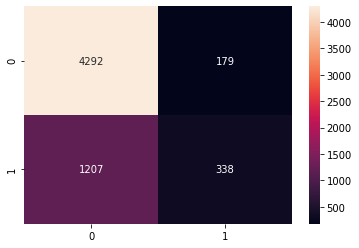

In [13]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOdds

In [14]:
fairdef='EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6851506233215332 | 0.7967143654823303 | 0.5221734084880636 | 0.658363726790451


In [15]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7689494680851063 | 0.6737034574468085
> DP | DI | DEOPP
> 0.0408327542245388 | 0.005571965128183365 | 0.003493078052997589
> Confusion Matrix 
TN: 4288.0 | FP: 183.0 
FN: 1207.0 | TP: 338.0
> Confusion Matrix for A = 0 
TN: 2610.0 | FP: 116.0 
FN: 1038.0 | TP: 289.0
> Confusion Matrix for A = 1 
TN: 1678.0 | FP: 67.0 
FN: 169.0 | TP: 49.0


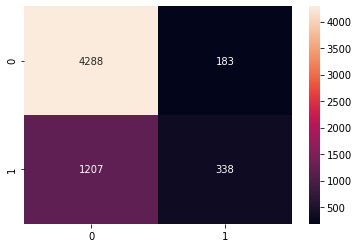

In [16]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOpp

In [17]:
fairdef='EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6931471824645996 | 0.7460233569145203 | 0.7528183023872679 | 0.6762267904509284


In [18]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7431848404255319 | 0.6737034574468085
> DP | DI | DEOPP
> 0.0 | 0.0 | 0.0
> Confusion Matrix 
TN: 4471.0 | FP: 0.0 
FN: 1545.0 | TP: 0.0
> Confusion Matrix for A = 0 
TN: 2726.0 | FP: 0.0 
FN: 1327.0 | TP: 0.0
> Confusion Matrix for A = 1 
TN: 1745.0 | FP: 0.0 
FN: 218.0 | TP: 0.0


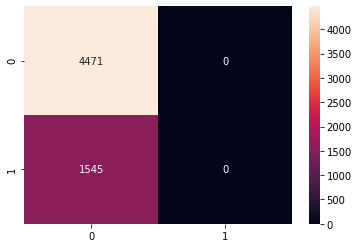

In [19]:
sns.heatmap(ret[4], annot=True, fmt='g')

## Models

In [20]:
#For DemPar
fairdef = 'DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4dp = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.9749710559844971 | 0.8043697476387024 | 0.2560096153846154 | 0.36480437665782495
> 2 | 0.6835649013519287 | 0.8118911385536194 | 0.5391661140583555 | 0.5693385278514589
> 3 | 0.6805155277252197 | 0.8280744552612305 | 0.7717175066312998 | 0.39903846153846156
> 4 | 0.673914909362793 | 0.8480638265609741 | 0.7740384615384616 | 0.39580570291777184
> 5 | 0.6732956171035767 | 0.8674333095550537 | 0.7744943633952255 | 0.34287964190981435
> 6 | 0.6731878519058228 | 0.8854891657829285 | 0.774618700265252 | 0.3237732095490716
> 7 | 0.6731693148612976 | 0.9012969732284546 | 0.7747430371352785 | 0.3237732095490716
> 8 | 0.673163652420044 | 0.9144887924194336 | 0.7747430371352785 | 0.3237732095490716
> 9 | 0.6731612086296082 | 0.9251226782798767 | 0.7747430371352785 | 0.3237732095490716
> 10 | 0.6731599569320679 | 0.9334834814071655 | 0.7747430371352785 | 0.3237732095490716
Validation
> Class Acc | Adv Acc
> 0.772938829787234 | 0.3262965

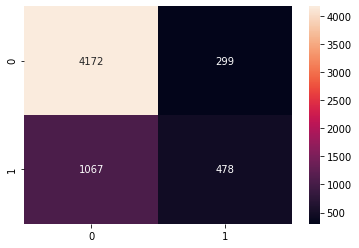

In [21]:
sns.heatmap(ret4dp[4], annot=True, fmt='g')

In [22]:
#For EqOdds
fairdef = 'EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4eqodds = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.7029163241386414 | 0.8072795271873474 | 0.5619612068965517 | 0.5903100132625995
> 2 | 0.698384165763855 | 0.8192301988601685 | 0.7498756631299734 | 0.4500994694960212
> 3 | 0.6934819221496582 | 0.8360385298728943 | 0.7520308355437666 | 0.3237732095490716
> 4 | 0.6931800842285156 | 0.8568706512451172 | 0.7526110742705571 | 0.3237732095490716
> 5 | 0.6931556463241577 | 0.8781079053878784 | 0.7527768567639257 | 0.3237732095490716
> 6 | 0.6931496858596802 | 0.8979756832122803 | 0.7529011936339522 | 0.3237732095490716
> 7 | 0.6931479573249817 | 0.9154213666915894 | 0.7529840848806366 | 0.3237732095490716
> 8 | 0.6931475400924683 | 0.9300652742385864 | 0.7529840848806366 | 0.3237732095490716
> 9 | 0.6931474208831787 | 0.9419866800308228 | 0.7529840848806366 | 0.3237732095490716
> 10 | 0.6931473016738892 | 0.9515005350112915 | 0.7529840848806366 | 0.3237732095490716
Validation
> Class Acc | Adv Acc
> 0.7431848404255319 | 0.32629654

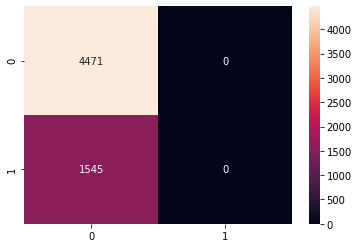

In [23]:
sns.heatmap(ret4eqodds[4], annot=True, fmt='g')

In [24]:
#For EqOpp
fairdef = 'EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4eqopp = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6942552328109741 | 0.7400873899459839 | 0.7681946286472149 | 0.665492374005305
> 2 | 0.6871994137763977 | 0.741269588470459 | 0.7701840185676393 | 0.4046750663129973
> 3 | 0.6851129531860352 | 0.7456992864608765 | 0.7710129310344828 | 0.37114555702917773
> 4 | 0.6850345134735107 | 0.7514598369598389 | 0.7716346153846154 | 0.3713942307692307
> 5 | 0.6850302815437317 | 0.757593035697937 | 0.772007625994695 | 0.3712698938992043
> 6 | 0.6850296258926392 | 0.7634601593017578 | 0.7721319628647215 | 0.3712698938992043
> 7 | 0.6850293874740601 | 0.7686902284622192 | 0.7722148541114058 | 0.37135278514588854
> 8 | 0.6850293874740601 | 0.7731290459632874 | 0.7722977453580901 | 0.3712698938992043
> 9 | 0.6850293278694153 | 0.7767676115036011 | 0.7723391909814323 | 0.3711870026525199
> 10 | 0.6850293278694153 | 0.7796920537948608 | 0.7726293103448276 | 0.3711870026525199
Validation
> Class Acc | Adv Acc
> 0.7694481382978724 | 0.374501329

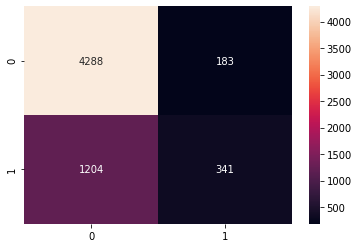

In [25]:
sns.heatmap(ret4eqopp[4], annot=True, fmt='g')

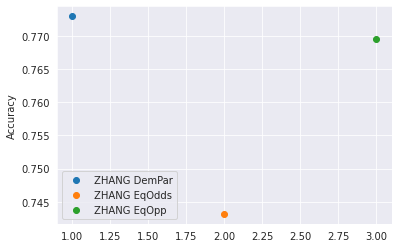

In [30]:
#x=[1,2,3]
#y = [tf.math.reduce_mean(ret4dp[0]),tf.math.reduce_mean(ret4eqodds[0]),tf.math.reduce_mean(ret4eqodds[0])]
y=[2,4,6]
#plt.scatter()
#plt.pyplot.grid(b=True, color='darkgrey')
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
#plt.scatter(x, y)

plt.scatter(1, ret4dp[0], label = "ZHANG DemPar")

plt.scatter(2, ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(3, ret4eqopp[0], label = "ZHANG EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

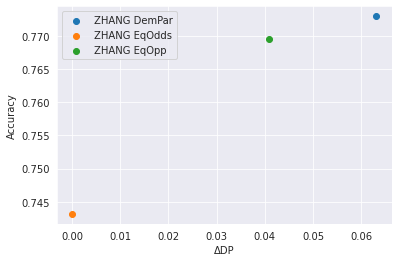

In [32]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''
#axes = plt.gca()
#axes.set_xlim([0.0643,0.0645])
plt.scatter(ret4dp[1], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

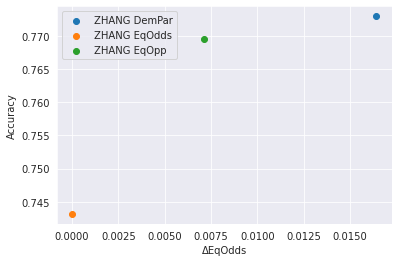

In [33]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[2], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

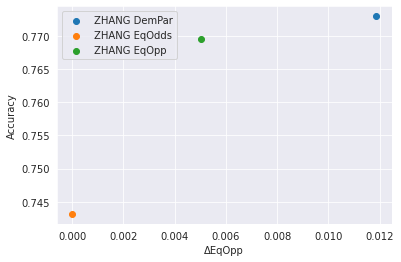

In [34]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[3], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()